In [1]:
#import packages

# examples/Python/Basic/python_binding.py

import open3d as o3d
# from open3d.web_visualizer import draw
import serial
import threading
import time
import keyboard
import ctypes  # An included library with Python install.   
import os
import copy
import matplotlib.pyplot as plt
import numpy as np
import inspect

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#define variables/objects

#reads in head model, computes normals, initializes vertex color array
####################################################

mesh = o3d.io.read_triangle_mesh("tri_head.obj")
mesh.compute_vertex_normals()
mesh.paint_uniform_color([0.5, 0.5, 0.5])

#####################################################

#defines basic color palatte for testing
####################################################

red = [1, 0, 0]
blue = [0, 0, 1]
green = [0, 1, 0]
gray = [0.5, 0.5, 0.5]
black = [0, 0, 0]
white = [1, 1, 1]

#####################################################

#defines rough array of indices corresponding to sensor points, 
#currently unfinished
####################################################

sensor = [[0, 7.53, 14.44], [0, 5.40, 17.73], [0, -3.1, 17.73], [-4.95, 3.03, 12.85], [-5.50, -1.24, 12.69], [0, -5.28, 13.37], [5.50, -1.24, 12.69], [4.95, 3.03, 12.85]]
testpoint = [0, 7, 14]
sensor2 = [[-2.2267, 0.5078, 18.705], [1.5174, 6.8428, 15.665], [-1.5174, 6.8428, 15.665], [-5.585, 0.9805, 13.258], [-3.1784, -4.4756, 11.993], [3.1784, -4.4756, 11.993], [5.585, 0.9805, 13.258], [2.2267, 0.5078, 18.705]]

#####################################################

In [3]:
#define functions

#3d distance calculation helper function

def dist_3d(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2+(p1[2]-p2[2])**2)

#low quality heatmap around a single point
#for testing purposes mainly

def heatmap(mesh):
    mesh.paint_uniform_color([0.5, 0.5, 0.5])
    ref = [5, 5, 5]#[l/r, fwd/back, vertical]
                    #[0 ~ center, ,7 ~ front of face, -6 ~ back , 20 ~ top]
    for c in range(len(mesh.vertices)):
        dist = dist_3d(ref, mesh.vertices[c])

#######################################################

    #shitty heatmap demo for use until I figure out the actual code
        if(dist < 2):
            mesh.vertex_colors[c] = red
        elif(2 <= dist < 3):
            mesh.vertex_colors[c] = green
        elif(3 <= dist < 5):
            mesh.vertex_colors[c] = blue

######################################################
 
#color in a region around one point, mainly used to highlight sensor regions

def color_point(point, mesh, color):
    for c in range(len(mesh.vertices)):
        dist = dist_3d(point, mesh.vertices[c])
        
        if(dist < 0.3):
            mesh.vertex_colors[c] = color
            
#colors the model in a spectrum along one axis,
#used for rough approximations of dimensions
            
def axis_spectrum(mesh):
    if len(mesh.vertex_colors) == 0:
        mesh.paint_uniform_color(gray)
    min_ = -6
    max_ = 8
    mid = 0.5 * (max_ + min_)
    index = 1
    
    for c in range(len(mesh.vertices)):
        dim = mesh.vertices[c][index]
        r = max(0, 1 - (dim-min_)/(mid-min_))
        b = max(0, (dim-min_)/(mid-min_) - 1)
        g = 1 - r - b
        mesh.vertex_colors[c] = [r, g, b]

#resets all mesh colors to gray

def clear_paint(mesh):
    mesh.paint_uniform_color(gray)

#sends popup notification with provided parameters

def notify(text = "sample text", title = "sample title"):
    ctypes.windll.user32.MessageBoxW(0, text, title, 0)

    

#basic threading functions, f1 displays the model to screen and f2 responds to key press for coloring etc

def f1():

# def show(object):
#     clear_paint(mesh)
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(mesh)

    while True:
        if keyboard.is_pressed('q'):
            break
        if keyboard.is_pressed('r'):
            # poll new data
            # referesh visualization with new heatmap
            axis_spectrum(mesh)
        vis.update_geometry(mesh)
        vis.poll_events()
        vis.update_renderer()

    vis.destroy_window()

# threading function

def f2(mesh):
    
    while True:
        if keyboard.is_pressed('c'):
            grid(mesh)
        elif keyboard.is_pressed('v'):
            axis_spectrum(mesh)
        elif keyboard.is_pressed('b'):
            notify()
            time.sleep(0.1)
        elif keyboard.is_pressed('q'):
            break
        
#            
#colors the model with a grid pattern


# >>> for count, value in enumerate(values):
# ...     print(count, value)
# ...
# 0 a
# 1 b
# 2 c


def grid(mesh):
    i = 0
    for c in mesh.vertices:
#         print(c)
        if( (1 < (10*c[0]) % 10 < 10) & (1 < (10*c[1]) % 10 < 10) & (1 < (10*c[2]) % 10 < 10) ):
            mesh.vertex_colors[i] = white
#             print('w')
        else:
            mesh.vertex_colors[i] = black
#             print('b')
        i+=1


In [4]:
#localization code demo

# region = [[0]*4]*3   #empty set of 3 3-d points with a weight vector-- [x, y, z, weight]
# print(region)


# Concept: Takes in 3(?) points in 3-space each with a weight
# Takes a weighted average of each dimension to localize a "hit"



def localize(points):
    w_sum = 0
    weights = [0] * len(points)
    out = [0, 0, 0]
    
    if len(points[0]) == 3:
        weights = [1/3, 1/3, 1/3]
    else:
        for p in points:
            w_sum += p[3]

        for i, p in enumerate(points):
            weights[i] = p[3]/w_sum
        
    for i, p in enumerate(points):
        for j in [0, 1, 2]:
            out[j] += (p[j]*weights[i])
#             print(out)
            
    return out


#Given 3 points return the vector normal to the plane

def normal(points):
    p0, p1, p2 = points
    
    if len(p0) == 3:
        x0, y0, z0 = p0
        x1, y1, z1 = p1
        x2, y2, z2 = p2
    else:
        x0, y0, z0, f0 = p0
        x1, y1, z1, f1 = p1
        x2, y2, z2, f2 = p2

    ux, uy, uz = u = [x1-x0, y1-y0, z1-z0] #first vector
    vx, vy, vz = v = [x2-x0, y2-y0, z2-z0] #sec vector

#     print(u)
#     print(v)
    
    cross = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx] #cross product
    
    mag = np.sqrt(cross[0]**2+cross[1]**2+cross[2]**2)
    
    return cross/mag

#Given the desired point, find the point on the model most closely corresponding to the point+normal vector

def nearest_normal(point, norm, mesh):
    
    p0, p1, p2 = point
#     n0, n1, n2 = norm
#     d=0
    vec = [0, 0, 0]
    best_l = [0, 0, 0]
    best_r = [0, 0, 0]
    best_dist_l = 999
    best_dist_r = 999
    norm_minus = -1 * norm
    
    
    for v in mesh.vertices:
#         Define the vector from the og point to model point
        vec[0] = p0 - v[0]
        vec[1] = p1 - v[1]
        vec[2] = p2 - v[2]
        
        mag = dist_3d(v, point)
        vec /= mag
#         compare the vector to the equal length normal vector
        comp = dist_3d(vec, norm)
        comp_minus = dist_3d(vec, norm_minus)
        
        if comp < best_dist_r:
            best_dist_r = comp
            best_r = v
            
        if comp_minus < best_dist_l:
            best_dist_l = comp_minus
            best_l = v
                
#     print("Left: " + str(best_l))
#     print("Right: " + str(best_r))
    if best_l[2] > 11:
        return best_l
    else:
        return best_r
#     return best_l, best_r

In [13]:
############################################################################################################################
########################################################Testing cells#######################################################
############################################################################################################################

In [4]:
#simple threading test

clear_paint(mesh)

t1 = threading.Thread(target=f1)
#     time.sleep(3)
t2 = threading.Thread(target=f2, args=(mesh,))

t1.start()
t2.start()

t1.join()
t2.join()

print("done")


done


In [8]:
#serial port test code
  
    
ser = serial.Serial('COM5', 9600) # use the appropriate serial port and baud rate

data = ser.readline().decode().rstrip() # throw out the starting up print

count = 0
id = 0
packet = np.zeros(8)

while True:
    
    if count == 0:
        id = int(ser.readline().decode().rstrip())
        count += 1
    else:
        d1 = int(ser.readline().decode().rstrip()) << 8
        d2 = int(ser.readline().decode().rstrip())
        packet[count - 1] = d1 + d2
        count += 1
        if count == 9:
            print(id)
            print(packet)
            count = 0
            ser.close()
            break

#     print(id)
#     print(packet)
    # read a line of daqta from the serial port
#     data = ser.readline().decode().rstrip()
#     print(type(data)) //defaults to string
#     time.sleep(1.5)

#     ser.close()
#     if keyboard.is_pressed('q'):
#         break
# ser.close()

100
[65535.     0.     0.     0.     0.     0.     0.     0.]


In [13]:
arr1 = [sensor2[4], sensor2[5], sensor2[7]]
arr2 = [sensor2[0], sensor2[1], sensor2[2], sensor2[3], sensor2[6]]


clear_paint(mesh)

for s in arr2:
    color_point(s, mesh, red)
for s in arr1:
    color_point(s, mesh, green)
    
point = localize(arr1)
# print(point)
n = normal(arr1)
# print(n)
n1 = nearest_normal(point, n, mesh)
# print(nn)
color_point(n1, mesh, blue)
# color_point(n2, mesh, black)

time.sleep(0.5)
    
o3d.visualization.draw_geometries([mesh])

[1.1666666666666667, 1.3333333333333333, 0.0]
[ 0.  0. -1.]


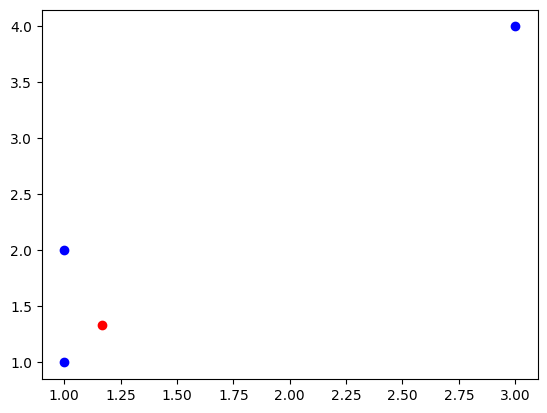

In [82]:

test = [[1, 1, 0, 10], [1, 2, 0, 1], [3, 4, 0, 1]]

ret = localize(test)

for t in test:
    plt.scatter(t[0], t[1], color='b')

plt.scatter(ret[0], ret[1], color = 'r')
print(ret)
print(normal(test))

In [1]:
# 
# Notes
# 

In [31]:
# Also, the for loop is cumbersome. As a general rule you will want to avoid using for loops in NumPy code. NumPy is implemented in C and Fortran, so if you avoid for loops the result often runs 100x faster than the equivalent loop.

# How do we get rid of this for loop? NumPy lets you index arrays with boolean arrays. You create a boolean array with logical operators. We can find all the doors in the hallway with:

# hallway == 1
# array([ True,  True, False, False, False, False, False, False,  True,
#        False])
# When you use the boolean array as an index to another array it returns only the elements where the index is `True`. Thus we can replace the `for` loop with
# ​
# ```python
# belief[hall==z] *= scale
# ```
# and only the elements which equal `z` will be multiplied by `scale`.
# ​
# Teaching you NumPy is beyond the scope of this book. I will use idiomatic NumPy constructs and explain them the first time I present them. If you are new to NumPy there are many blog posts and videos on how to use NumPy efficiently and idiomatically.
# ​
# Here is our improved version:

# from filterpy.discrete_bayes import normalize

# def scaled_update(hall, belief, z, z_prob): 
#     scale = z_prob / (1. - z_prob)
#     belief[hall==z] *= scale
#     normalize(belief)

# belief = np.array([0.1] * 10)
# scaled_update(hallway, belief, z=1, z_prob=.75)

# print('sum =', sum(belief))
# print('probability of door =', belief[0])
# print('probability of wall =', belief[2])
# book_plots.bar_plot(belief, ylim=(0, .3))

In [102]:
# print(sensor2[0:3])

[[-2.2267, 0.5078, 18.705], [1.5174, 6.8428, 15.665], [-1.5174, 6.8428, 15.665]]


In [105]:
n = normal(sensor2[0:3])
print(n)

[3.7441000000000004, 6.335000000000001, -3.039999999999999]
[0.7093, 6.335000000000001, -3.039999999999999]
[0.         0.43263853 0.90156747]
